In [1]:
import os
import sys
threads_num = 2
os.environ["MKL_NUM_THREADS"] = f"{threads_num}" 
os.environ["NUMEXPR_NUM_THREADS"] = f"{threads_num}"
os.environ["OMP_NUM_THREADS"] = f"{threads_num}"
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy
import numpy as np
import pandas as pd
import genmodel

from utils import colors, sample_type_to_color, sample_type_to_label, export_legend, transform_model, merge_vdj_alleles, full_js_distance, draw_distances, get_distance_stats_test, draw_pvalues

sns.set_style("ticks")

In [2]:
DATA_DIR = "../data/greiff_cell_reports_naive/"
SYNTHETIC_DATA_DIR = "../data/mouse_synthetic_replicates/"
TEST_DATA_DIR = "../data/greiff_cell_reports_naive_test/"
FIGURES_DIR = "../figures/figure_2/"

In [3]:
sample_types = ["synthetic", "data", "technical", "twins"]
sample_sizes = [1000, 3000, 10000, 30000]

# start

In [4]:
technical_replicates = ['Sample_20_OVA_mouse_2_stimulus_ovalbumin_ERR1759686',
                       'Sample_20_OVA_mouse_2_stimulus_ovalbumin_ERR1759689']
individuals = ["Sample_11_C57BL6_mouse_4_stimulus_none_ERR1759674",
               "Sample_17_OVA_mouse_1_stimulus_ovalbumin_ERR1759683",
               "Sample_20_OVA_mouse_2_stimulus_ovalbumin_ERR1759686",
               "Sample_23_OVA_mouse_3_stimulus_ovalbumin_ERR1759692",
               "Sample_26_OVA_mouse_4_stimulus_ovalbumin_ERR1759695",
               "Sample_29_OVA_mouse_5_stimulus_ovalbumin_ERR1759698",
               "Sample_2_C57BL6_mouse_1_stimulus_none_ERR1759665",
               "Sample_35_NP-HEL_mouse_1_stimulus_4-hydroxy-3-nitrophenylacetyl_conjugated_to_hen_egg_lysozyme_ERR1759630",
               "Sample_38_NP-HEL_mouse_2_stimulus_4-hydroxy-3-nitrophenylacetyl_conjugated_to_hen_egg_lysozyme_ERR1759635",
               "Sample_41_NP-HEL_mouse_3_stimulus_4-hydroxy-3-nitrophenylacetyl_conjugated_to_hen_egg_lysozyme_ERR1759638",
               "Sample_44_NP-HEL_mouse_4_stimulus_4-hydroxy-3-nitrophenylacetyl_conjugated_to_hen_egg_lysozyme_ERR1759641",
               "Sample_47_NP-HEL_mouse_5_stimulus_4-hydroxy-3-nitrophenylacetyl_conjugated_to_hen_egg_lysozyme_ERR1759644",
               "Sample_50_HBsAg_mouse_1_stimulus_Hepatitis_B_virus_surface_antigen_ERR1759647",
               "Sample_53_HBsAg_mouse_2_stimulus_Hepatitis_B_virus_surface_antigen_ERR1759650",
               "Sample_56_HBsAg_mouse_3_stimulus_Hepatitis_B_virus_surface_antigen_ERR1759653",
               "Sample_59_HBsAg_mouse_4_stimulus_Hepatitis_B_virus_surface_antigen_ERR1759656",
               "Sample_5_C57BL6_mouse_2_stimulus_none_ERR1759668",
               "Sample_8_C57BL6_mouse_3_stimulus_none_ERR1759671"]

In [5]:
def get_distance_stats(n_sequences, exclude=[]):
    synthetic_replicate_models = []
    data_replicate_models = []
    technical_replicate_models = []
    technical_data_replicate_models = []
    main_models = []
    for synthetic_id in [4, 5, 6, 7]:
        prefix = os.path.join(SYNTHETIC_DATA_DIR, f"synthetic_replicate_{synthetic_id}_{n_sequences}_run/main_inference/final")
        synthetic_replicate_models.append(genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                        marginals_file=prefix + "_marginals.txt"))
    for individual in technical_replicates:
        prefix = os.path.join(DATA_DIR, f"{individual}_{n_sequences}_run/main_inference/final")
        technical_replicate_models.append(genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                        marginals_file=prefix + "_marginals.txt"))
    for individual in technical_replicates:
        prefix = os.path.join(DATA_DIR, f"{individual}_data_replicate_{n_sequences}_run/main_inference/final")
        technical_data_replicate_models.append(genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                        marginals_file=prefix + "_marginals.txt"))

    for individual in individuals:
        prefix = os.path.join(DATA_DIR, f"{individual}_{n_sequences}_run/main_inference/final")
        main_models.append(genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                        marginals_file=prefix + "_marginals.txt"))
        prefix = os.path.join(DATA_DIR, f"{individual}_data_replicate_{n_sequences}_run/main_inference/final")
        data_replicate_models.append(genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                        marginals_file=prefix + "_marginals.txt"))
    
    
    
    trasformed_synthetic_replicate_models = [transform_model(m) for m in synthetic_replicate_models]
    trasformed_data_replicate_models = [transform_model(m) for m in data_replicate_models]
    trasformed_technical_replicate_models = [transform_model(m) for m in technical_replicate_models]
    trasformed_technical_data_replicate_models = [transform_model(m) for m in technical_data_replicate_models]
    trasformed_main_models = [transform_model(m) for m in main_models]
    
    synthetic_replicate_distances = [full_js_distance(trasformed_synthetic_replicate_models[i],
                                                      trasformed_synthetic_replicate_models[k],
                                                      exclude=exclude) \
                                   for i in range(len(synthetic_replicate_models)) for k in range(i+1, len(synthetic_replicate_models))]
    data_replicate_distances = [full_js_distance(trasformed_main_models[i],
                                                 trasformed_data_replicate_models[i],
                                                 exclude=exclude) \
                                   for i in range(len(main_models))]
    technical_replicate_distances = [full_js_distance(trasformed_technical_replicate_models[i],
                                                      trasformed_technical_replicate_models[k],
                                                      exclude=exclude) \
                                   for i in range(len(technical_replicates)) for k in range(i+1, len(technical_replicates))] + \
                                    [full_js_distance(trasformed_technical_data_replicate_models[i],
                                                      trasformed_technical_data_replicate_models[k],
                                                      exclude=exclude) \
                                   for i in range(len(technical_data_replicate_models)) for k in range(i+1, len(technical_data_replicate_models))] + \
                                    [full_js_distance(trasformed_technical_replicate_models[i],
                                                      trasformed_technical_data_replicate_models[k],
                                                      exclude=exclude) \
                                   for i in range(len(technical_replicates)) for k in range(i+1, len(technical_data_replicate_models))] + \
                                    [full_js_distance(trasformed_technical_data_replicate_models[i],
                                                      trasformed_technical_replicate_models[k],
                                                      exclude=exclude) \
                                   for i in range(len(technical_data_replicate_models)) for k in range(i+1, len(technical_replicates))]
                                    
    main_distances = [full_js_distance(trasformed_main_models[i],
                                       trasformed_main_models[k],
                                       exclude=exclude) \
                                   for i in range(len(individuals)) for k in range(i+1, len(individuals))]
    
    return {"synthetic": synthetic_replicate_distances,
            "data": data_replicate_distances,
            "technical": technical_replicate_distances,
            "twins": main_distances}



In [6]:
exclude = []
statistics = {}
for n_sequences in sample_sizes:
    for sample_type in sample_sizes:
        statistics[n_sequences] = get_distance_stats(n_sequences, exclude)

In [7]:
ylim_explicit = (0, 1)
ylim_normalized = (0.95, 1.69)

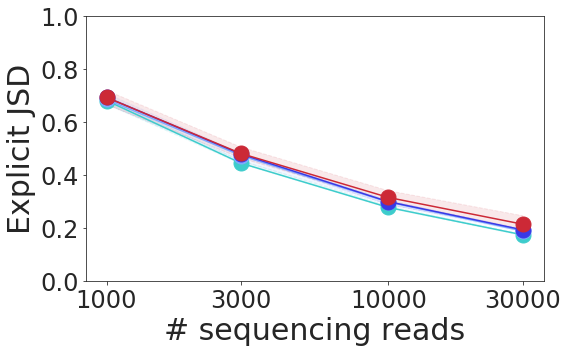

In [8]:
draw_distances(statistics, sample_types=sample_types, normalize=False, ylim=ylim_explicit, output_filename=os.path.join(FIGURES_DIR, "greiff_cell_reports_naive_explicit.png"))

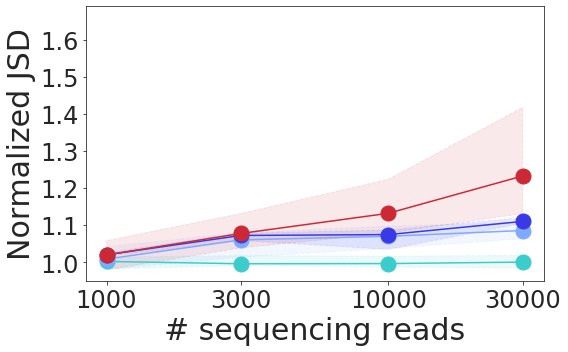

In [9]:
draw_distances(statistics, sample_types=sample_types, normalize=True, ylim=ylim_normalized, output_filename=os.path.join(FIGURES_DIR, "greiff_cell_reports_naive_normalized.png"))

# legend

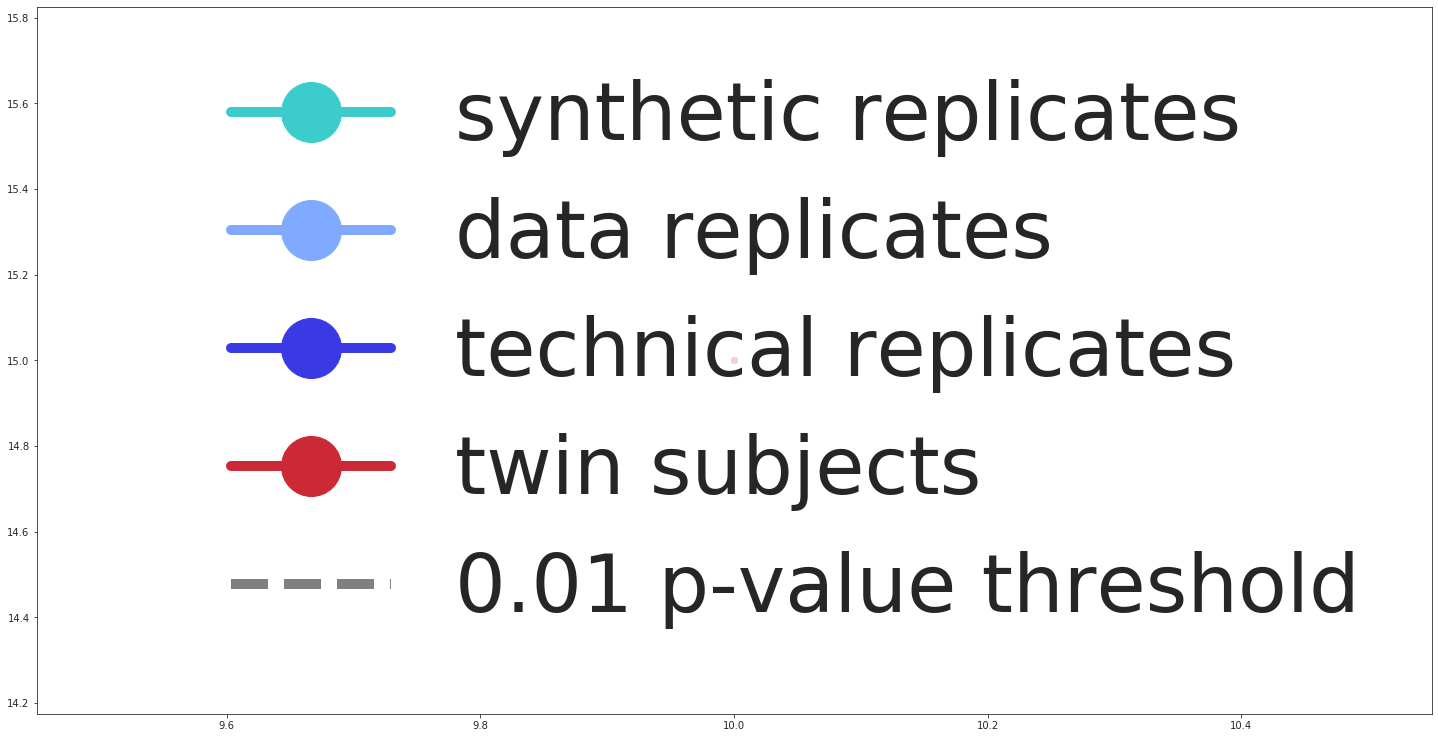

In [10]:
fig = plt.figure(figsize=(25, 13))
fontsize = 25
x = [10, 10]
y = [15, 15]

for sample_type in statistics[1000].keys():
    plt.plot(x, y, color=sample_type_to_color[sample_type], label=sample_type_to_label[sample_type], marker='o')
plt.plot(x, y, color="grey", linestyle="--", label="0.01 p-value threshold")
    
    
sc_coef = 4
leg = plt.legend(fontsize=fontsize * 0.8 * sc_coef, markerscale=2.5 * sc_coef)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.5 * sc_coef)
export_legend(leg, filename=os.path.join(FIGURES_DIR, "legend_mice.png"))
plt.show()

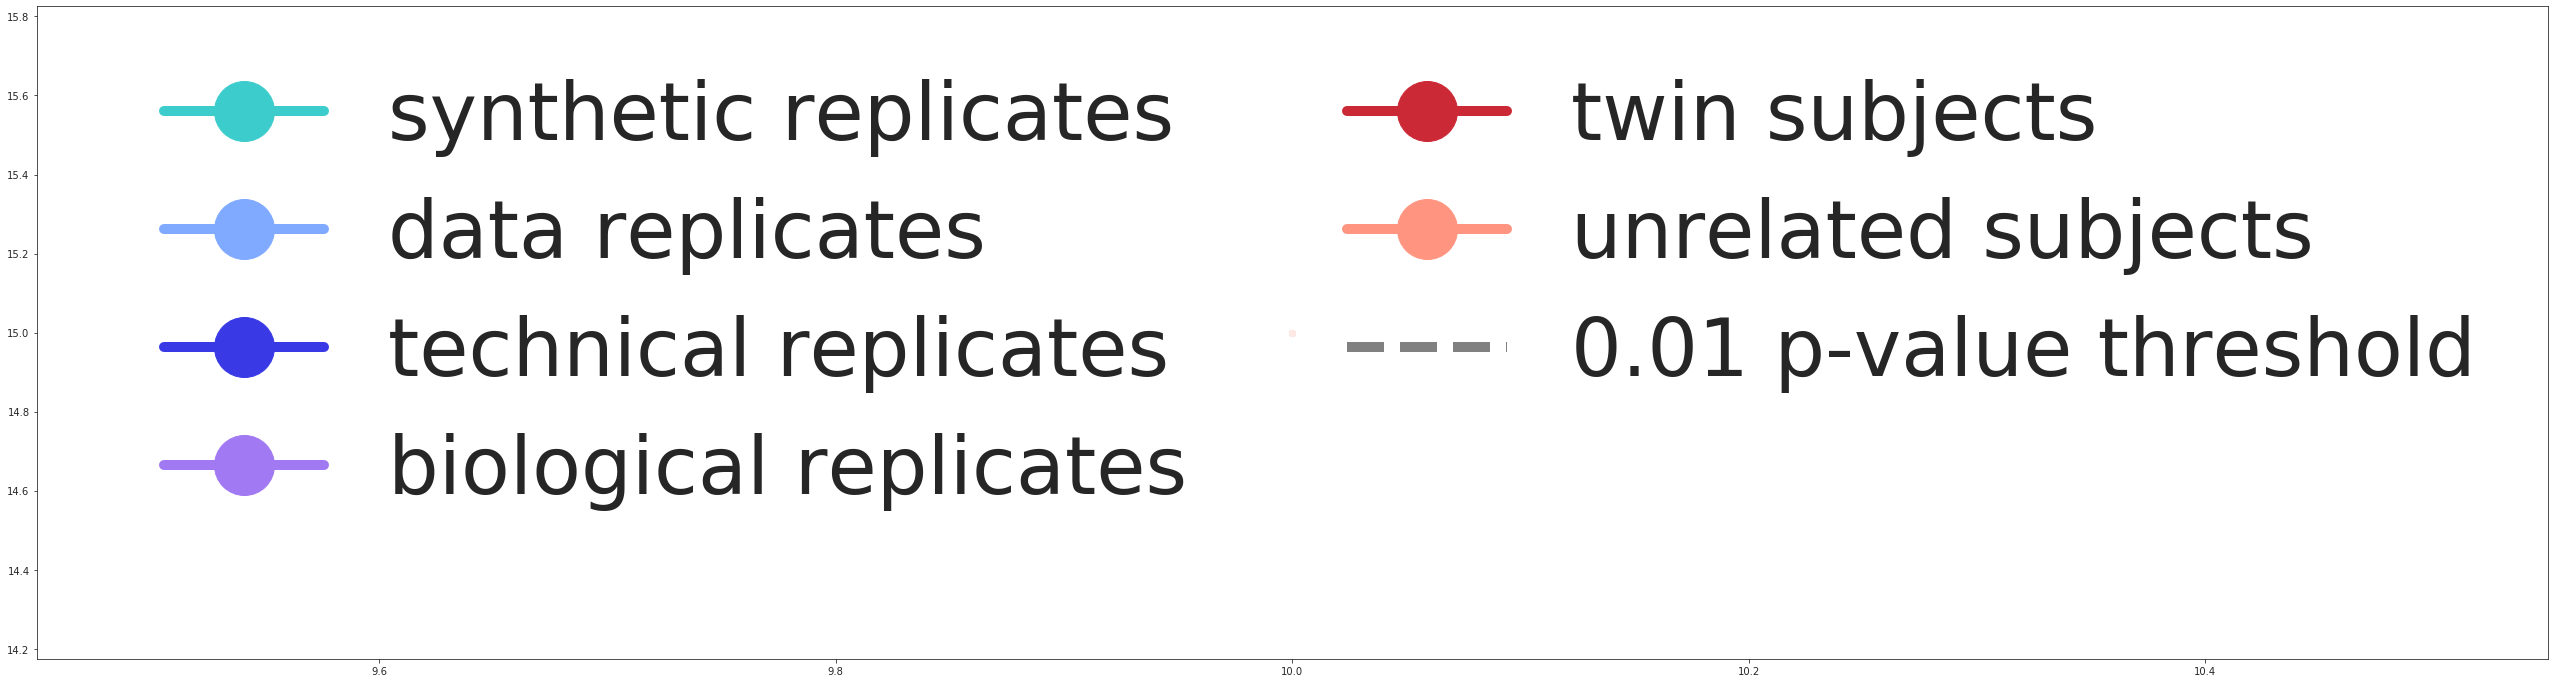

In [11]:
fig = plt.figure(figsize=(45, 12))
fontsize = 25
x = [10, 10]
y = [15, 15]

for sample_type in ["synthetic", "data", "technical", "biological", "twins", "unrelated"]:
    plt.plot(x, y, color=sample_type_to_color[sample_type], label=sample_type_to_label[sample_type], marker='o')
plt.plot(x, y, color="grey", linestyle="--", label="0.01 p-value threshold")
    
    
sc_coef = 4
leg = plt.legend(fontsize=fontsize * 0.8 * sc_coef, markerscale=2.5 * sc_coef, ncol=2)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.5 * sc_coef)
export_legend(leg, filename=os.path.join(FIGURES_DIR, "legend_all.png"))
plt.show()

In [12]:
test_distances = {}
names = ["data", "technical", "twins"]
for n_sequences in sample_sizes:
    test_distances[n_sequences] = {}
    main_distances, other_distances = get_distance_stats_test(TEST_DATA_DIR, n_sequences, names, merge=False)
    test_distances[n_sequences]["self"] = main_distances
    for name in names:
        test_distances[n_sequences][name] = other_distances[name]
    


In [13]:
pvalues = {}
n_tests = len(sample_sizes) * len(names)
for n_sequences in sample_sizes:
    pvalues[n_sequences] = {}
    for name in names:
        pvalues[n_sequences][name] = scipy.stats.ttest_ind(test_distances[n_sequences]["self"],
                                                           test_distances[n_sequences][name],
                                                           equal_var=False,
                                                           alternative="less").pvalue * n_tests

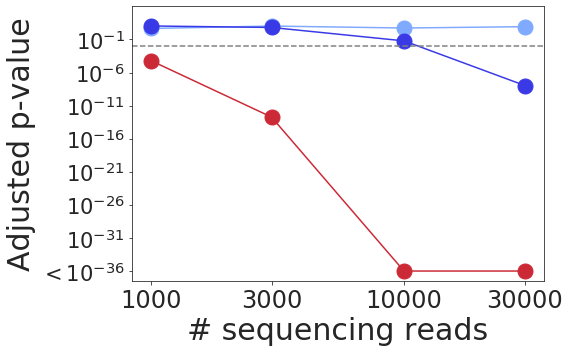

In [14]:
draw_pvalues(pvalues, names, output_filename=os.path.join(FIGURES_DIR, "greiff_cell_reports_naive_pvalue.png"))

# non-v

In [15]:
exclude = ["v_delv", "v_d_j"]
statistics_no_v = {}
for n_sequences in sample_sizes:
    for sample_type in sample_sizes:
        statistics_no_v[n_sequences] = get_distance_stats(n_sequences, exclude)

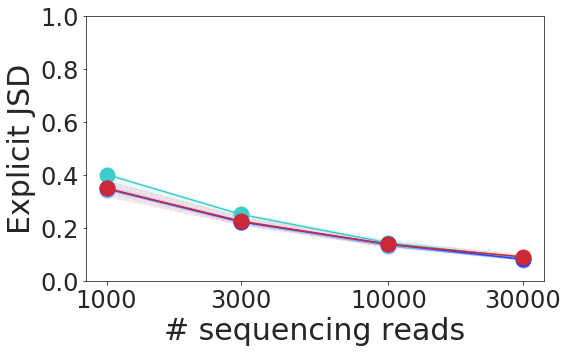

In [16]:
draw_distances(statistics_no_v, sample_types=sample_types, normalize=False, ylim=ylim_explicit, output_filename=os.path.join(FIGURES_DIR, "greiff_cell_reports_explicit_no_v.png"))

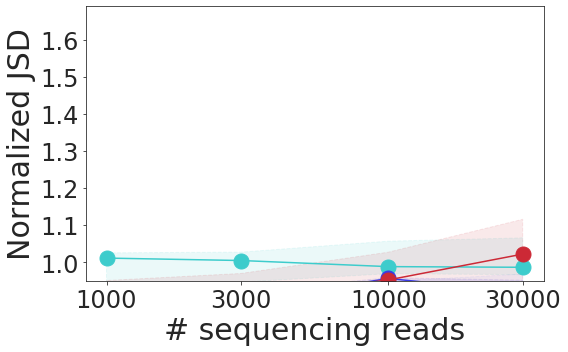

In [17]:
draw_distances(statistics_no_v, sample_types=sample_types, normalize=True, ylim=ylim_normalized, output_filename=os.path.join(FIGURES_DIR, "dewitt_plos_one_normalized_no_v.png"))

# only v

In [18]:
keys = {'v_delv', 'd_deld', 'dj_ins', 'j_delj', 'v_d_j', 'vd_ins'}

In [19]:
exclude = keys - {"v_delv", "v_d_j"}
statistics_only_v = {}
for n_sequences in sample_sizes:
    for sample_type in sample_sizes:
        statistics_only_v[n_sequences] = get_distance_stats(n_sequences, exclude)

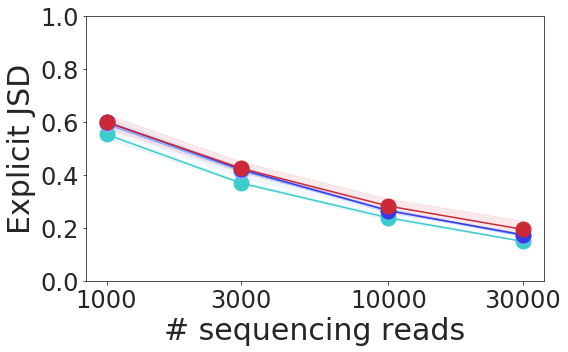

In [20]:
draw_distances(statistics_only_v, sample_types=sample_types, normalize=False, ylim=ylim_explicit, output_filename=os.path.join(FIGURES_DIR, "greiff_cell_reports_explicit_only_v.png"))

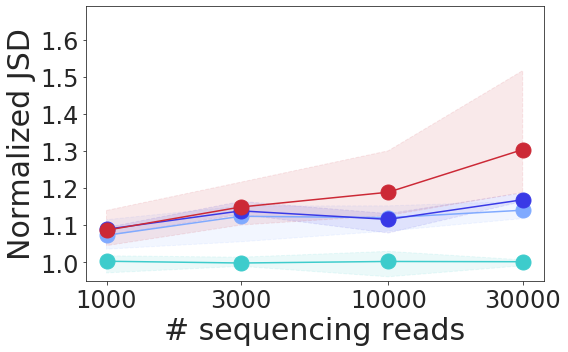

In [21]:
draw_distances(statistics_only_v, sample_types=sample_types, normalize=True, ylim=ylim_normalized, output_filename=os.path.join(FIGURES_DIR, "greiff_cell_reports_normalized_only_v.png"))